In [1]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
# A helper function for downloading files
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

# Hands-on Activity 13.4: Measures of Predictive Accuracy

## Objectives

+ To introduce measures that quantify how good a regression model is.

## Validation dataset

You cannot test how good your model is using the training dataset.
Whatever the metric you use, the performance of your model on the training dataset will always be quite good.
This is because the model is tuned to do well on the training data.
The real question is how well your model does on a dataset it has never see.
This brings us to the concept of a *validation dataset*.
How can you make a validation dataset?
Well, take whatever data you have a split it into training and validation dataset.
For example, you can randomly select 70% of your data and put it in your training set and 30% of the data and put it in your validation set.

## Example - Motorcyle data
Let's do this for the motorcyle dataset:

In [3]:
# The url of the motorcycle data:
#url = 'https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/activities/motor.dat'
# Download the data
#download(url)
# Load the data
data = np.loadtxt('motor.dat')
# Figure out how many observations you have
num_obs = data.shape[0]
# Select what percentage you want to put in the training data
train_percentage = 0.7
# Figure out how many training points you are going to use:
num_train = int(num_obs * train_percentage)
# Figure out how many validation points you are going to use:
num_valid = num_obs - num_train
print('num_train = {0:d}, num_valid = {1:d}'.format(num_train, num_valid))

num_train = 65, num_valid = 29


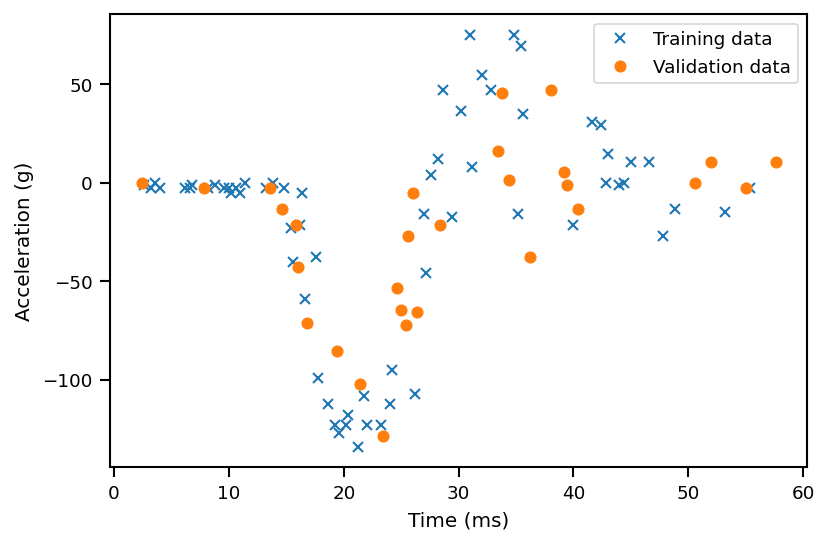

In [4]:
# Before splitting the data, randomly permute rows
permuted_data = np.random.permutation(data)
# Now we split in a training set
train_data = permuted_data[:num_train] # This picks the first n_train rows
# and a validation set
valid_data = permuted_data[num_train:] # This puts the rest on the validation rows
# Get the x's and the y's for regression
x_train = train_data[:, 0]
y_train = train_data[:, 1]
# Get the x's and the y's for validation
x_valid = valid_data[:, 0]
y_valid = valid_data[:, 1]
# Let's plot the training and the validation datasets in different colors
fig, ax = plt.subplots(dpi=150)
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_valid, y_valid, 'o', label='Validation data')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best');

Let's repeat here the code that calculates the design matrix for polynomial, Fourier, and radial basis functions:

In [5]:
def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

def get_fourier_design_matrix(x, L, num_terms):
    """
    Fourier expansion with ``num_terms`` cosines and sines.
    
    Arguments:
    
        L           -       The "length" of the domain.
        num_terms   -       How many Fourier terms do you want. This is not the number
                            of basis functions you get. The number of basis functions
                            is 1 + num_terms / 2. The first one is a constant.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(int(num_terms / 2)):
        cols.append(np.cos(2 * (i+1) * np.pi / L * x))
        cols.append(np.sin(2 * (i+1) * np.pi / L * x))
    return np.hstack(cols)
                    
def get_rbf_design_matrix(x, x_centers, ell):
    """
    Radial basis functions design matrix.
    
    Arguments:
        x          -     the input points on which you want to evaluate the
                         design matrix
        x_center   -     the centers of the radial basis functions
        ell        -     the lengthscale of the radial basis function
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

We will start fitting a polynomial model, plotting the response, and the prediction vs observations plot:

MSE_poly = 9257.99


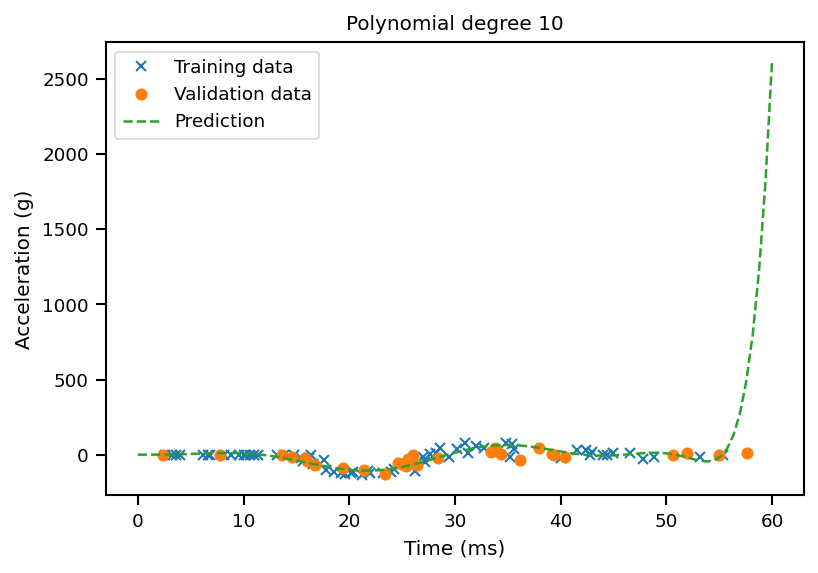

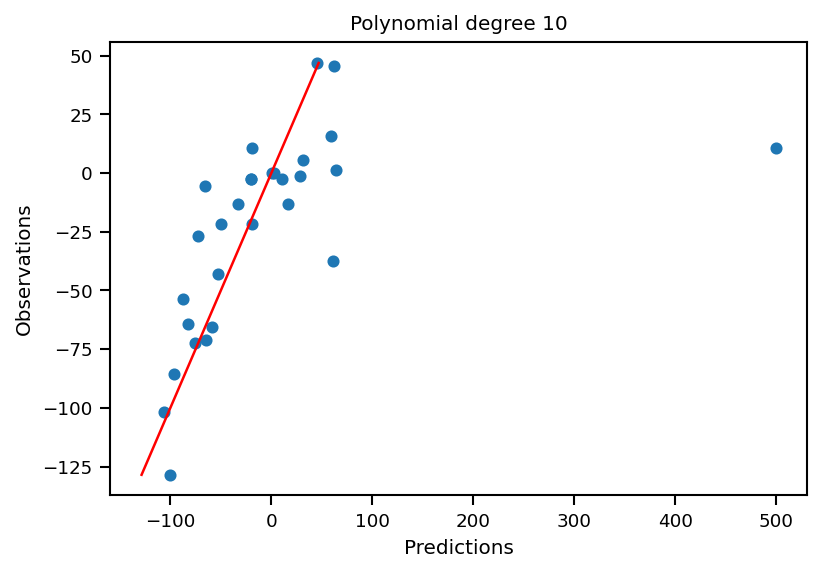

In [9]:
# Fit the polynomial model
degree = 10
Phi_poly_train = get_polynomial_design_matrix(x_train[:, None], degree)
w_poly, _, _, _ = np.linalg.lstsq(Phi_poly_train, y_train, rcond=None)

# Plot the predictions
xx = np.linspace(0, 60, 100)
Phi_poly_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy_predict = np.dot(Phi_poly_xx, w_poly)
fig, ax = plt.subplots(dpi=150)
ax.set_title('Polynomial degree {0:d}'.format(degree))
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_valid, y_valid, 'o', label='Validation data')
ax.plot(xx, yy_predict, '--', label='Prediction')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best')

# Make predictions on the validation data
Phi_poly_valid = get_polynomial_design_matrix(x_valid[:, None], degree)
y_valid_predict = np.dot(Phi_poly_valid, w_poly)
# Calculate the mean square error
MSE_poly = np.mean((y_valid_predict - y_valid) ** 2)
print('MSE_poly = {0:1.2f}'.format(MSE_poly))
# Do the predictsions vs observations plots
fig, ax = plt.subplots(dpi=150)
ax.set_title('Polynomial degree {0:d}'.format(degree))
ax.plot(y_valid_predict, y_valid, 'o')
yys = np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');

### Questions

+ Experiment with polynomials of degree 4, 5, 10, 20
+ When are we underfitting?
+ When are we overfitting?
+ Which degree (if any) gives you the best fit?
+ Use the code blocks below to repeat this analysis for the Fourier basis and the radial basis functions. Which choice of the three basis functions seems to be better? Why?

MSE_fourier = 485.34


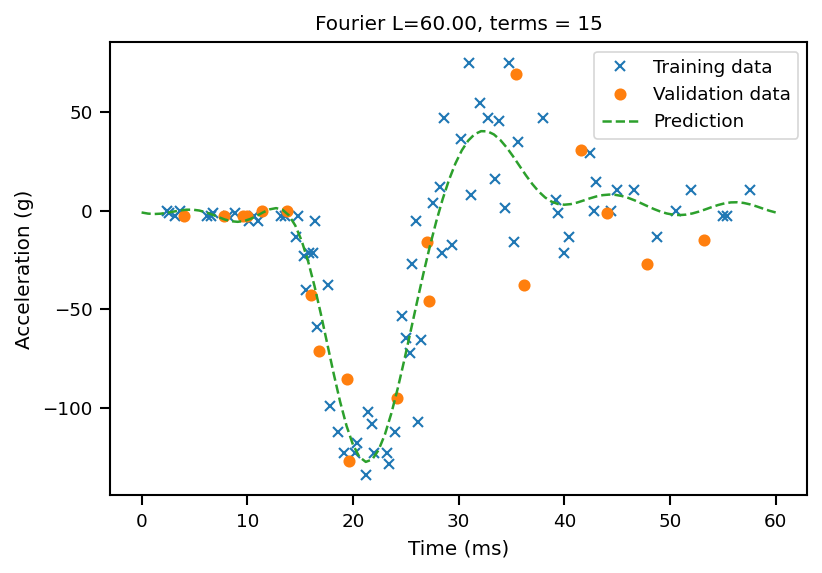

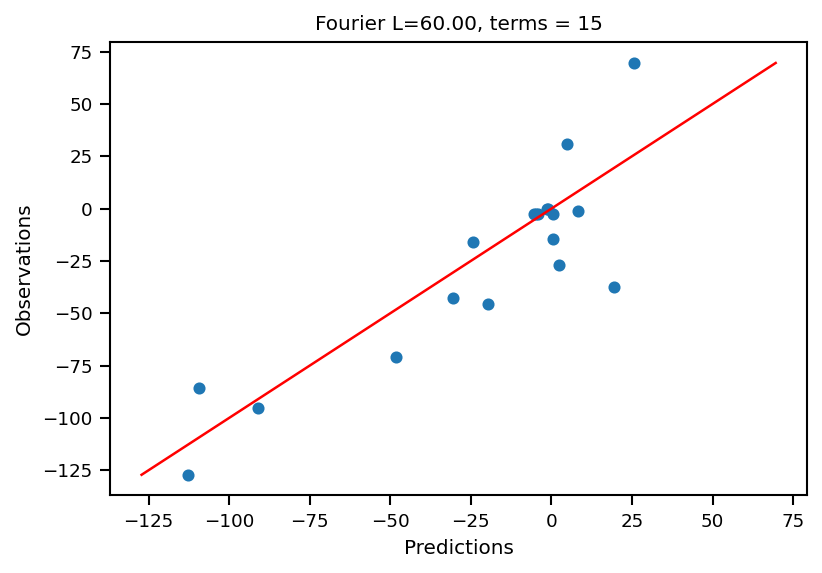

In [16]:
# Fit the Fourier model
fourier_terms = 15
fourier_L = 60.0
Phi_fourier_train = get_fourier_design_matrix(x_train[:, None], fourier_L, fourier_terms)
w_fourier, _, _, _ = np.linalg.lstsq(Phi_fourier_train, y_train, rcond=None)

# Plot the predictions
xx = np.linspace(0, 60, 100)
Phi_fourier_xx = get_fourier_design_matrix(xx[:, None], fourier_L, fourier_terms)
yy_predict = np.dot(Phi_fourier_xx, w_fourier)
fig, ax = plt.subplots(dpi=150)
ax.set_title('Fourier L={0:1.2f}, terms = {1:d}'.format(fourier_L, fourier_terms))
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_valid, y_valid, 'o', label='Validation data')
ax.plot(xx, yy_predict, '--', label='Prediction')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best')

# Make predictions on the validation data
Phi_fourier_valid = get_fourier_design_matrix(x_valid[:, None], fourier_L, fourier_terms)
y_valid_predict = np.dot(Phi_fourier_valid, w_fourier)
# Calculate the mean square error
MSE_fourier = np.mean((y_valid_predict - y_valid) ** 2)
print('MSE_fourier = {0:1.2f}'.format(MSE_fourier))
## Do the predictsions vs observations plots
fig, ax = plt.subplots(dpi=150)
ax.set_title('Fourier L={0:1.2f}, terms = {1:d}'.format(fourier_L, fourier_terms))
ax.plot(y_valid_predict, y_valid, 'o')
yys = np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');

MSE_rbf = 924.70


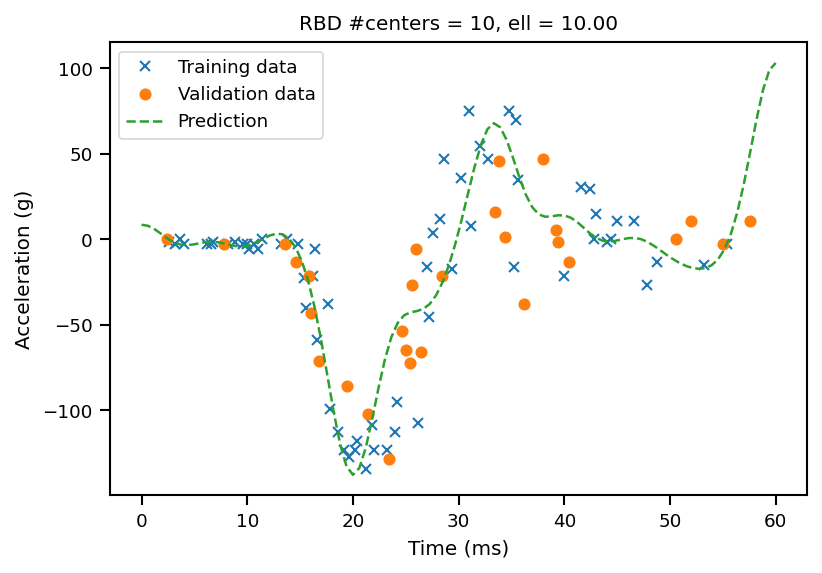

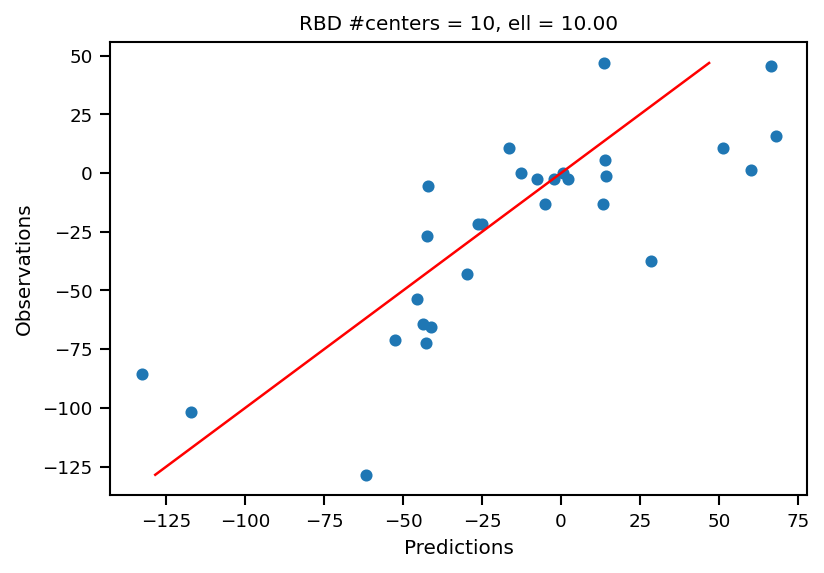

In [11]:
# Fit the RBF model
rbf_centers = np.linspace(0.0, 60.0, 10)
rbf_ell = 10
Phi_rbf_train = get_rbf_design_matrix(x_train[:, None], rbf_centers, rbf_ell)
w_rbf, _, _, _ = np.linalg.lstsq(Phi_rbf_train, y_train, rcond=None)
# Plot the function when possible
xx = np.linspace(0, 60, 100)
Phi_rbf_xx = get_rbf_design_matrix(xx[:, None], rbf_centers, rbf_ell)
yy_predict = np.dot(Phi_rbf_xx, w_rbf)
fig, ax = plt.subplots(dpi=150)
ax.set_title('RBD #centers = {0:d}, ell = {1:1.2f}'.format(rbf_centers.shape[0], rbf_ell))
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_valid, y_valid, 'o', label='Validation data')
ax.plot(xx, yy_predict, '--', label='Prediction')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best')
# Make predictions on the validation data
Phi_rbf_valid = get_rbf_design_matrix(x_valid[:, None], rbf_centers, rbf_ell)
y_valid_predict = np.dot(Phi_rbf_valid, w_rbf)
# Calculate the mean square error
MSE_rbf = np.mean((y_valid_predict - y_valid) ** 2)
print('MSE_rbf = {0:1.2f}'.format(MSE_rbf))
## Do the predictsions vs observations plots
fig, ax = plt.subplots(dpi=150)
ax.set_title('RBD #centers = {0:d}, ell = {1:1.2f}'.format(rbf_centers.shape[0], rbf_ell))
ax.plot(y_valid_predict, y_valid, 'o')
yys = np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');

## Using the mean square error to select the number of basis functions

Let's now use the MSE of the validation dataset to select the number of basis functions.

In [12]:
# Start increasing the number of Fourier terms and check the mean square error
# Fit the Fourier model
MSE = []
for fourier_terms in range(1, 20):
    fourier_L = 60.0
    Phi_fourier_train = get_fourier_design_matrix(x_train[:, None], fourier_L, fourier_terms)
    w_fourier, _, _, _ = np.linalg.lstsq(Phi_fourier_train, y_train, rcond=None)
    # Make predictions on the validation data
    Phi_fourier_valid = get_fourier_design_matrix(x_valid[:, None], fourier_L, fourier_terms)
    y_valid_predict = np.dot(Phi_fourier_valid, w_fourier)
    # Calculate the mean square error
    MSE_fourier = np.mean((y_valid_predict - y_valid) ** 2)
    MSE.append(MSE_fourier)

We should now have all MSE for different number of terms:

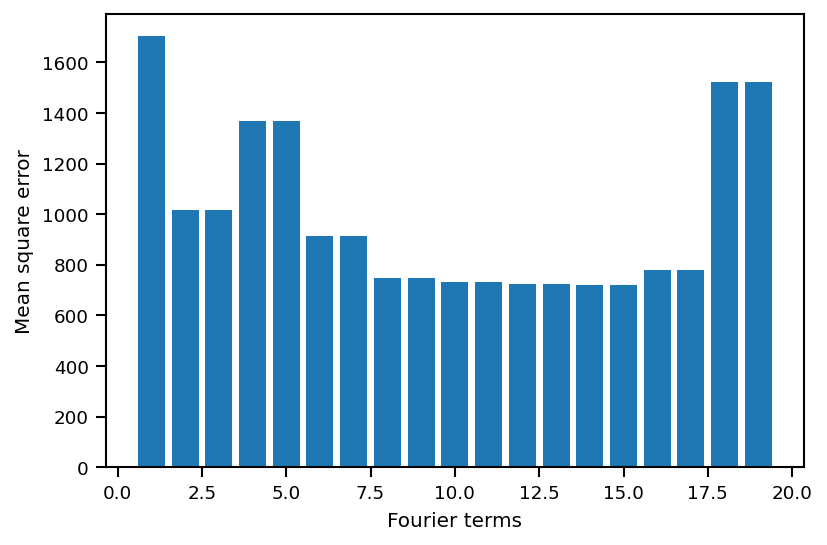

In [13]:
fig, ax = plt.subplots(dpi=150)
ax.bar(range(1, len(MSE)+1), MSE)
ax.set_xlabel('Fourier terms')
ax.set_ylabel('Mean square error');

Finally, let's use cross validation to estimate the validation MSE.
Remember that in cross validation we split the original dataset several times, not just once. Here is the code:

In [14]:
# Cross validation
# Start increasing the number of Fourier terms and check the mean square error
# Fit the Fourier model
MSE = []
num_folds = 100
fourier_L = 60.0
train_percentage = 0.8
# Figure out how many training points you are going to use:
num_train = int(num_obs * train_percentage)
# Figure out how many validation points you are going to use:
num_valid = num_obs - num_train
for fourier_terms in range(1, 20):
    mse_sum = 0.0
    for fold in range(num_folds):
        permuted_data = np.random.permutation(data)
        train_data = permuted_data[:num_train]
        valid_data = permuted_data[num_train:]
        x_train = train_data[:, 0]
        y_train = train_data[:, 1]
        x_valid = valid_data[:, 0]
        y_valid = valid_data[:, 1]
        Phi_fourier_train = get_fourier_design_matrix(x_train[:, None], fourier_L, fourier_terms)
        w_fourier, _, _, _ = np.linalg.lstsq(Phi_fourier_train, y_train, rcond=None)
        # Make predictions on the validation data
        Phi_fourier_valid = get_fourier_design_matrix(x_valid[:, None], fourier_L, fourier_terms)
        y_valid_predict = np.dot(Phi_fourier_valid, w_fourier)
        # Calculate the mean square error
        MSE_fourier = np.mean((y_valid_predict - y_valid) ** 2)
        mse_sum += MSE_fourier
    MSE.append(mse_sum / num_folds)

And here are the results:

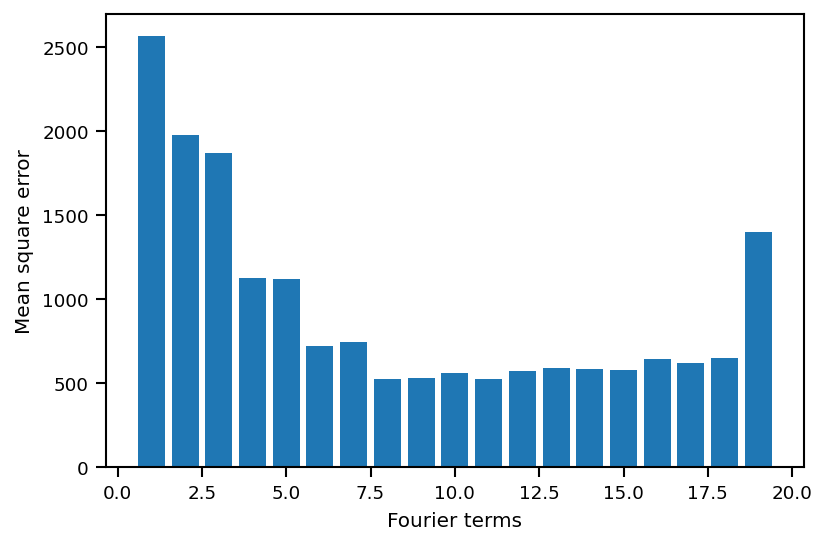

In [15]:
fig, ax = plt.subplots(dpi=150)
ax.bar(range(1, len(MSE)+1), MSE)
ax.set_xlabel('Fourier terms')
ax.set_ylabel('Mean square error');

### Questions
+ Modify the code blocks above to use radial basis functions instead of the Fourier basis. How many terms do you need for a given lengthscale?